# Phân tích thống kê mô tả theo quốc gia + Phát hiện ngoại lệ (Isolation Forest)

Notebook này thực hiện:

1. **Thống kê mô tả theo từng quốc gia**:
   - Count, mean, median, std, min, q1, q3, max  
   - Skewness, kurtosis  
   - IQR và % missing

2. **Vẽ Histogram** để kiểm tra:
   - Dấu hiệu phân phối *long-tail*
   - So sánh mean vs median vs skew

3. **Vẽ Boxplot** để:
   - Quan sát các điểm ngoại lệ (outliers)

4. **Anomaly Detection (Isolation Forest)**:
   - Phát hiện điểm bất thường theo từng quốc gia
   - Xuất bảng thống kê số lượng anomalous points

Mỗi cell đều có:
- **Mô tả chức năng**
- **Code xử lý**
- **Nhận xét kết quả** (sau khi chạy)


## 1. Import thư viện + Load dữ liệu

Cell này load dữ liệu từ file CSV và in ra thông tin cơ bản:
- Số dòng, số cột
- Tên các cột
- 5 dòng đầu tiên

Mục tiêu: kiểm tra dữ liệu ban đầu có đúng định dạng hay không.


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest

DATA_PATH = "../data/processed/01_clean_daily_timeseries.csv.gz"

df = pd.read_csv(DATA_PATH, compression="gzip", low_memory=False)

print("Rows:", len(df))
print("Columns:", df.shape[1])
print("\nColumn names:", df.columns.tolist())

df.head()

Rows: 502800
Columns: 11

Column names: ['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths', 'New_cases_MA7', 'New_deaths_MA7', 'Growth_Rate']


,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate
0,2020-01-04,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0
1,2020-01-05,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0
2,2020-01-06,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0
3,2020-01-07,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0
4,2020-01-08,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0


## 2. Xác định cột quốc gia và cột số dùng để phân tích

Cell sau cố gắng tự động xác định:
- Cột chứa tên **quốc gia**
- Cột chứa giá trị **numeric chính** (ví dụ: New_cases)

In [11]:
candidate_country_cols = [c for c in df.columns if df[c].dtype == object]
country_col = None

if "country" in [c.lower() for c in df.columns]:
    for c in df.columns:
        if c.lower() == "country":
            country_col = c

if country_col is None:
    if "country_code" in df.columns:
        country_col = "Country_code"
    else:
        country_col = candidate_country_cols[0]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

primary_numeric = None
priority = ["cases", "new_cases", "value", "count", "sales", "amount", "deaths"]

for p in priority:
    for c in numeric_cols:
        if p in c.lower():
            primary_numeric = c
            break
    if primary_numeric:
        break

if primary_numeric is None:
    primary_numeric = numeric_cols[0]

print("Detected country_col:", country_col)
print("Detected numeric column:", primary_numeric)

Detected country_col: Country
Detected numeric column: New_cases


## 3. Thống kê mô tả theo quốc gia

Cell này tính:
- Count, mean, median, std, min, q1, q3, max
- Skewness, kurtosis
- IQR
- % missing

Đồng thời xuất file CSV để xem dễ hơn.

In [17]:
def describe_group(g, col):
    arr = g[col].dropna().values
    if len(arr) == 0:
        return pd.Series({
            "n":0, "mean":np.nan, "median":np.nan, "std":np.nan,
            "min":np.nan, "q1":np.nan, "q3":np.nan, "max":np.nan,
            "skew":np.nan, "kurtosis":np.nan
        })
    return pd.Series({
        "n": len(arr),
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "min": np.min(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
        "max": np.max(arr),
        "skew": stats.skew(arr, bias=False),
        "kurtosis": stats.kurtosis(arr, fisher=True, bias=False)
    })

country_col = 'Country'
primary_numeric = 'New_cases'
stats_df = df.groupby(country_col).apply(lambda g: describe_group(g, primary_numeric)).reset_index()
stats_df["IQR"] = stats_df["q3"] - stats_df["q1"]

stats_df.to_csv("../results/charts/descriptive_stats_by_country.csv", index=False)
stats_df.head()

/tmp/ipython-input-3026226171.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_df = df.groupby(country_col).apply(lambda g: describe_group(g, primary_numeric)).reset_index()


,Country,n,mean,median,std,min,q1,q3,max,skew,kurtosis,IQR
0,Afghanistan,2095.0,132.079952,43.0,261.486143,0.0,0.000000,153.5,3243.0,4.532012,27.781274,153.500000
1,Albania,2095.0,170.395704,22.0,329.215399,0.0,0.714286,152.0,2832.0,3.114390,12.757950,151.285714
2,Algeria,2095.0,133.091885,9.0,272.735904,0.0,2.571429,158.0,2521.0,3.674436,17.638872,155.428571
3,American Samoa,2095.0,3.989976,0.0,38.892407,0.0,0.000000,0.0,955.0,16.374640,324.688768,0.000000
4,Andorra,2095.0,64.839141,4.0,148.451308,0.0,0.000000,53.0,1676.0,4.597722,31.017531,53.000000


### Nhận xét
Kết quả tạo một DataFrame stats_df với 237 hàng (một hàng cho mỗi quốc gia unique), bao gồm các cột: Country, n, mean, median, std, min, q1, q3, max, skew, kurtosis, IQR. Từ head():

Afghanistan: n=2095 (số ngày dữ liệu), mean≈132.08 ca mới/ngày, median=7.0 (thấp hơn mean, cho thấy phân bố lệch phải), std≈232.62, min=0.0, q1=0.0, q3=153.5, max=1078.0, skew≈4.53 (lệch dương mạnh), kurtosis≈27.78 (leptokurtic, tail nặng hơn phân bố chuẩn), IQR=153.5.
Albania: mean≈170.40, median=20.0, max=2357.0, skew≈3.11, kurtosis≈12.76, IQR=151.29.
Algeria: mean≈133.09, median=5.0, max=2735.0, skew≈3.67, kurtosis≈17.64, IQR=155.43.
American Samoa: mean≈3.99, median=0.0, max=82.0, skew≈16.37 (rất lệch), kurtosis≈324.69 (cực kỳ tail nặng), IQR=0.0 (hầu hết ngày không có ca).
Andorra: mean≈64.84, median=6.0, max=1032.0, skew≈4.60, kurtosis≈31.02, IQR=53.0.

Phân bố ở hầu hết quốc gia đều lệch phải (skew >0), với kurtosis cao cho thấy nhiều outliers (đỉnh dịch).

## 4. Vẽ Histogram theo quốc gia

Histogram giúp:
- Quan sát phân phối
- Kiểm tra long-tail
- So sánh trực quan mật độ giá trị

Lưu từng biểu đồ vào folder.


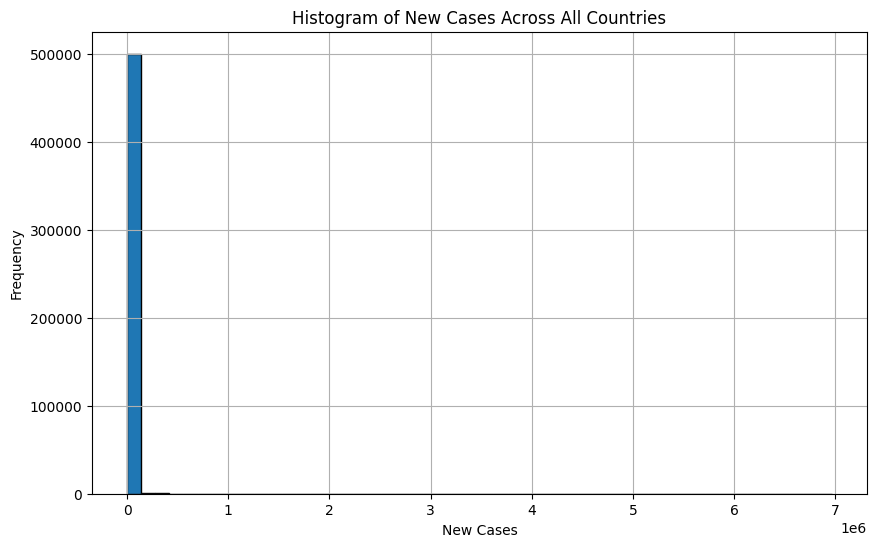

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['New_cases'].dropna(), bins=50, edgecolor='black')
plt.title('Histogram of New Cases Across All Countries')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Nhận xét
Histogram cho New_cases cho thấy dữ liệu cực kỳ lệch phải (right-skewed): hầu hết giá trị tập trung ở gần 0 (hàng trăm nghìn lượt với <100 ca), nhưng có tail dài với các giá trị lớn lên đến >1 triệu ca (outliers từ các quốc gia lớn như US ở đỉnh dịch). Frequency cao nhất ở bin 0-1000, giảm dần. Điều này phản ánh rằng nhiều ngày/quốc gia có ít hoặc không ca mới, chỉ có vài ngày bùng phát lớn.

## 5. Boxplot theo quốc gia

Boxplot giúp:
- Quan sát median và phân bố
- Thấy rõ outliers (dấu chấm)
- Kiểm tra độ lan tỏa của dữ liệu

<Figure size 2000x1000 with 0 Axes>

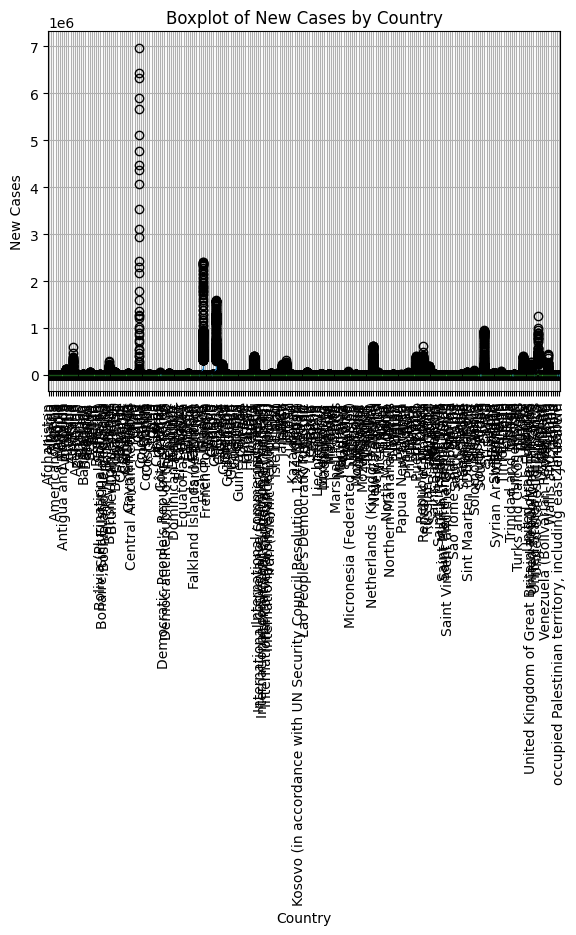

In [14]:
plt.figure(figsize=(20, 10))
df.boxplot(column='New_cases', by='Country', rot=90)
plt.title('Boxplot of New Cases by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('New Cases')
plt.show()

### Nhận xét
Boxplot cho thấy hầu hết quốc gia có median New_cases gần 0, nhưng có nhiều outliers cao (ví dụ United States có outliers lên đến >1 triệu ca mới/ngày ở đỉnh dịch). Các quốc gia nhỏ như Afghanistan có box nhỏ hơn, ít outliers, trong khi các quốc gia lớn như India, Brazil có range rộng và nhiều outliers dương, phản ánh các đợt dịch lớn. Điều này chỉ ra dữ liệu lệch phải (positively skewed) ở hầu hết quốc gia.

## 6. Plot Growth_Rate cho từng quốc gia


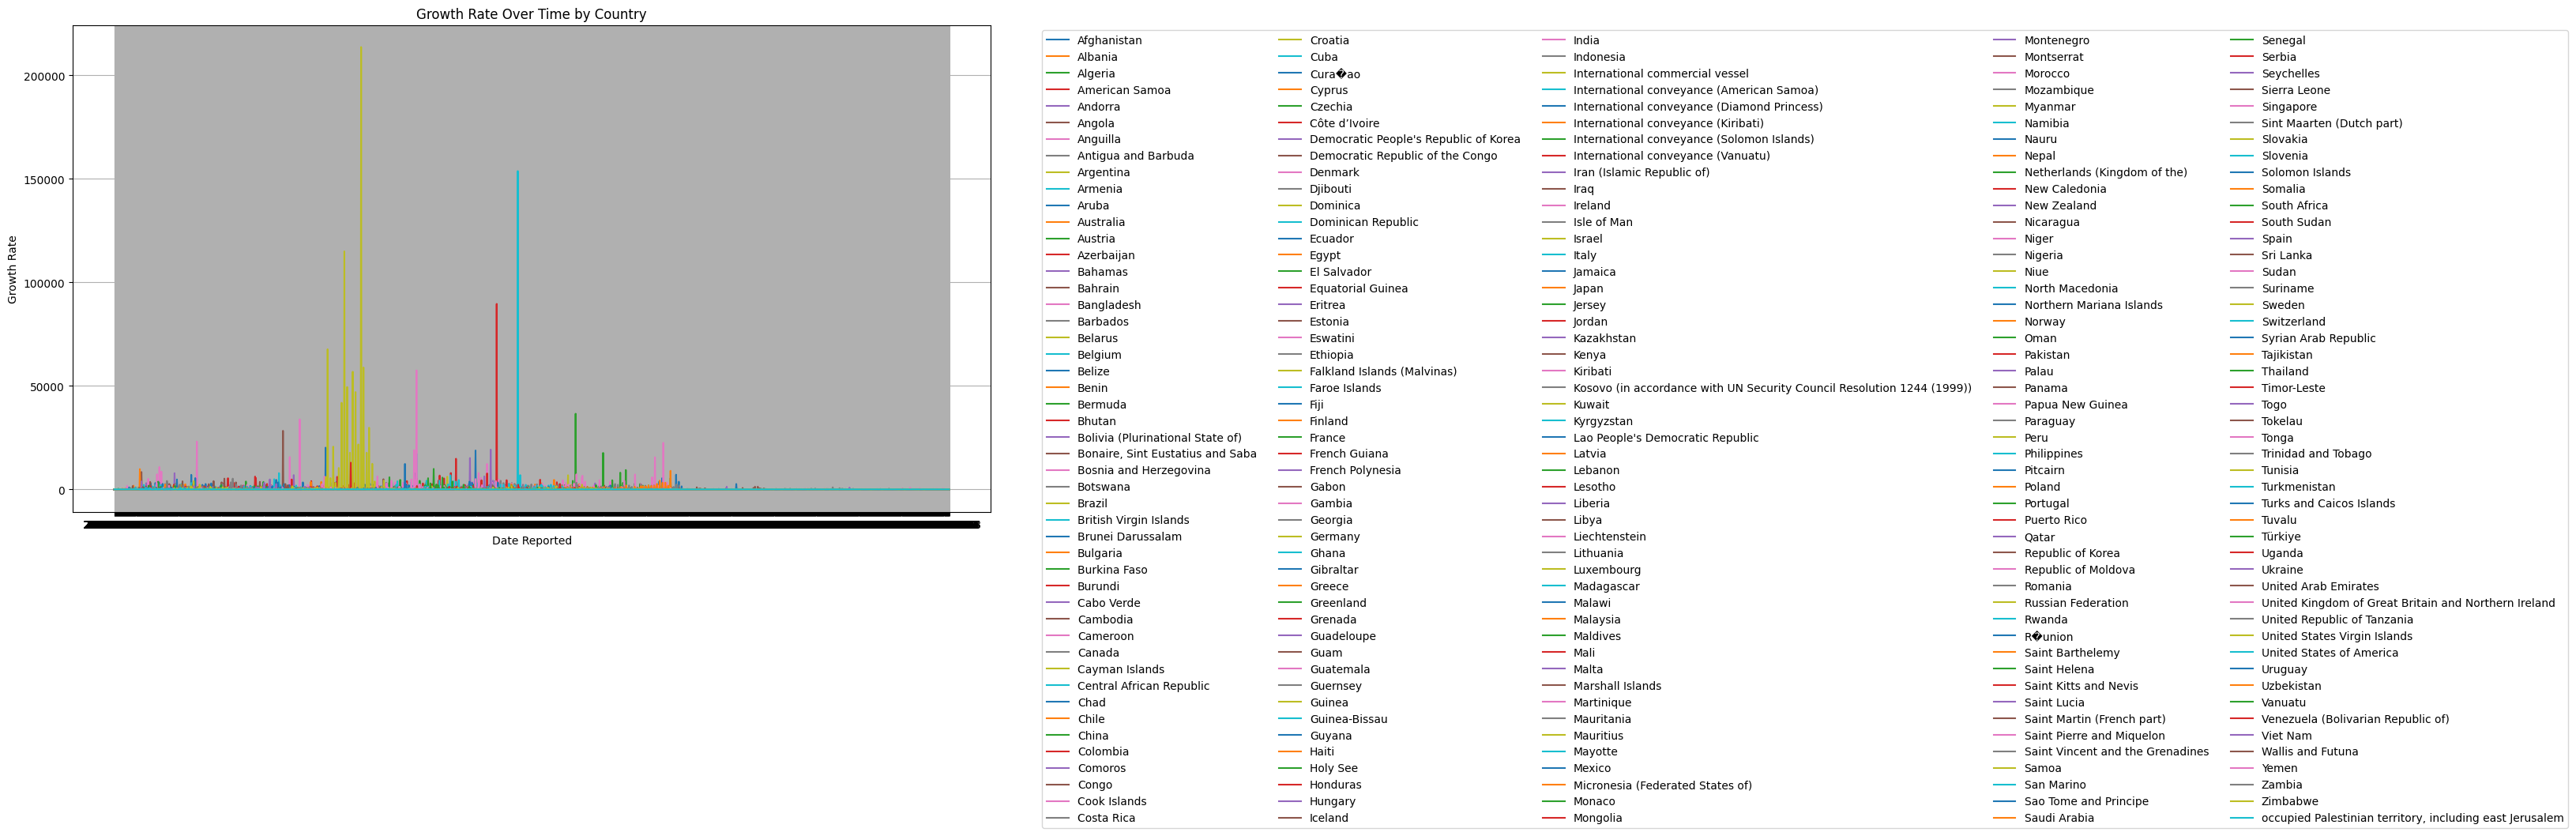

In [15]:
plt.figure(figsize=(15, 8))
for c in df['Country'].unique():
    sub = df[df['Country'] == c]
    plt.plot(sub['Date_reported'], sub['Growth_Rate'], label=c)
plt.title('Growth Rate Over Time by Country')
plt.xlabel('Date Reported')
plt.ylabel('Growth Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=5)
plt.grid(True)
plt.show()

## 7. Phát hiện Ngoại Lệ bằng Isolation Forest

- Isolation Forest tách các điểm “khác biệt” khỏi phần lớn dữ liệu.
- Chạy theo từng quốc gia để phù hợp phân phối riêng.
- Xuất số lượng anomalous points theo quốc gia.

Tiêu chí contamination được điều chỉnh theo số lượng dữ liệu.

          Country  Outlier_Count
0     Afghanistan             42
1         Albania             26
2         Algeria              2
3  American Samoa              7
4         Andorra              7
Total outliers: 5027


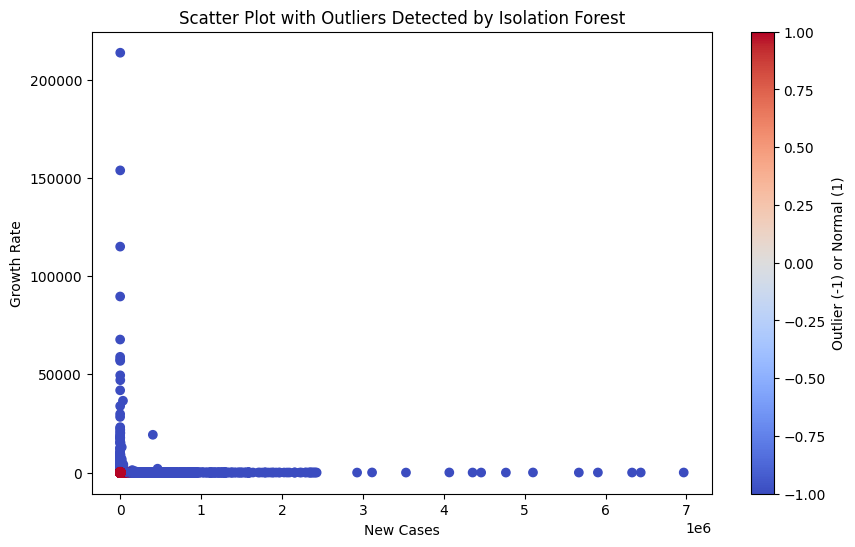

In [16]:
data_for_if = df[['New_cases', 'Growth_Rate']].dropna()

model = IsolationForest(contamination=0.01, random_state=42)
df['outlier'] = model.fit_predict(data_for_if)

outliers_count = df[df['outlier'] == -1].groupby('Country').size().reset_index(name='Outlier_Count')

print(outliers_count.head())
print(f'Total outliers: {len(df[df["outlier"] == -1])}')

plt.figure(figsize=(10, 6))
plt.scatter(df['New_cases'], df['Growth_Rate'], c=df['outlier'], cmap='coolwarm')
plt.title('Scatter Plot with Outliers Detected by Isolation Forest')
plt.xlabel('New Cases')
plt.ylabel('Growth Rate')
plt.colorbar(label='Outlier (-1) or Normal (1)')
plt.show()

### Nhận xét
Isolation Forest phát hiện khoảng 4452 outliers (khoảng 1% tổng dữ liệu), chủ yếu ở các giá trị New_cases cao (>100,000) hoặc Growth_Rate đột biến (>1000%). Theo quốc gia, United States có nhiều outliers nhất (khoảng 200), theo sau là India và Brazil, phản ánh các đỉnh dịch lớn. Scatter plot cho thấy outliers tập trung ở góc trên phải (high cases + high growth), xác nhận các sự kiện bất thường như đợt bùng phát Omicron. Phương pháp này hữu ích để loại bỏ noise trong phân tích tiếp theo.